This Jupyter notebook demonstrates how to implement a Convolutional Neural Network (CNN) from scratch, using only basic libraries and no high-level frameworks for the core computations.

 **Importing Libraries**


*   **TensorFlow**: Used here solely to load the MNIST dataset.
*   **NumPy:** Provides support for large multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions.



In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

**Defining the Convolutional Layer**


*   **Initialization**: The constructor initializes the number of kernels, kernel size, stride, bias, and the kernels themselves.
*   **Partition Generator**: Generates partitions of the image to apply the convolution operation.


*   **Forward Propagation**: Performs the convolution operation on the input image and returns the feature maps.
*   **Backward Propagation**: Updates the kernels based on the gradients and learning rate.





In [2]:
class ConvolutionLayers:
  def __init__(self,kernel_num,kernel_size,stride = 1,bias = 1):

    self.no_of_kernels = kernel_num
    self.kernel_size = kernel_size
    self.stride = stride
    self.bias = bias
    self.kernels = np.random.randn(kernel_num,kernel_size,kernel_size) / kernel_size**2

  def partition_generator(self,input_img):
    img_h,img_w = input_img.shape
    self.img = input_img
    for h in range(0,img_h-self.kernel_size+1,self.stride):
      for w in range(0,img_w - self.kernel_size+1,self.stride):
        slice = input_img[h:(h+self.kernel_size),w:(w+self.kernel_size)]
        yield slice,h,w

  def forward_prop(self,img):
    img_h,img_w = img.shape
    conv_output = np.zeros((img_h-self.kernel_size+1,img_w-self.kernel_size+1,self.no_of_kernels))
    for sec,h,w in self.partition_generator(img):
      conv_output[h,w] = np.sum(sec*self.kernels,axis = (1,2))
    return conv_output

  def backward_prop(self,dL_dZ,learning_rate):
      dL_dk = np.zeros(self.kernels.shape)
      for sec,h,w in self.partition_generator(self.img):
        for f in range(self.no_of_kernels):
          dL_dk += sec*dL_dZ[h,w,f]
      self.kernels -= learning_rate*dL_dk
      return dL_dk


**Defining the Max Pooling Layer**
MaxPool class performs the max pooling operation to reduce the spatial dimensions of the input feature maps.



*   **Initialization**: Initializes the pool size and stride.

*   **Partition Generator**: Generates partitions of the image for pooling.


*   **Forward Propagation:** Performs max pooling on the input feature maps.
*   **Backward Propagation:** Distributes the gradients back through the pooling layer.






In [3]:
class MaxPool:
  def __init__(self,pool_size,stride):
    self.pool_size = pool_size
    self.stride = stride

  def partition_generator(self,img):
    img_h,img_w = img.shape[0]//self.pool_size,img.shape[1]//self.pool_size
    self.img = img
    for h in range(0,img_h,self.stride):
      for w in range(0,img_w,self.stride):
        slice = img[(h*self.pool_size):(h*self.pool_size+self.pool_size),(w*self.pool_size):(w*self.pool_size+self.pool_size)]
        yield slice,h,w

  def forward_prop(self,img):
    h,w,num_kernels = img.shape
    max_pooled_out = np.zeros((h//self.pool_size,w//self.pool_size,num_kernels))
    for slice,h,w in self.partition_generator(img):
      max_pooled_out[h,w] = np.amax(slice,axis = (0,1))
    return max_pooled_out

  def backward_prop(self,dL_dZ):

    dL_dk = np.zeros(self.img.shape)
    for patch,h,w in self.partition_generator(self.img):
      h0, w0, num_kernels = patch.shape
      max_val = np.amax(patch, axis=(0,1))
      for idx_h in range(h0):
        for idx_w in range(w0):
          for idx_k in range(num_kernels):
            if patch[idx_h,idx_w,idx_k] == max_val[idx_k]:
              dL_dk[h*self.pool_size+idx_h, w*self.pool_size+idx_w, idx_k] = dL_dZ[h,w,idx_k]
      return dL_dk


**Defining the Fully Connected and Softmax Layer**
The FullyCon_SoftmaxLayer class implements the fully connected layer followed by a softmax activation, which is used for classification.

*   **Initialization**: Initializes weights and biases.
*   **Dense Layer**: Flattens the input and applies the fully connected layer.


*   **Softmax Output**: Computes the softmax activation.
*   **Forward Propagation**: Combines the dense layer and softmax operations.


*   **Backward Propagation**: Updates the weights and biases based on the gradients and learning rate.








In [4]:
class FullyCon_SoftmaxLayer:
    def __init__(self, input_units, output_units):
        self.weight = np.random.randn(input_units, output_units) / input_units
        self.bias = np.zeros(output_units)
        self.output = None

    def _dense_layer(self, image):
        self.original_shape = image.shape
        image_flattened = image.flatten()
        self.flattened_input = image_flattened
        dense_output = np.dot(image_flattened, self.weight) + self.bias
        self.output = dense_output
        return dense_output

    def _softmax_out(self, dense_out):
        softmax_output = np.exp(dense_out) / np.sum(np.exp(dense_out), axis=0)
        return softmax_output

    def forward_prop(self, image):
        dense_out = self._dense_layer(image)
        softmax_output = self._softmax_out(dense_out)
        return softmax_output

    def backward_prop(self, dL_dz, lr):
        for i, gradient in enumerate(dL_dz):
            if gradient == 0:
                continue
            transformation_eq = np.exp(self.output)
            S_total = np.sum(transformation_eq)

            dY_dZ = -transformation_eq[i]*transformation_eq / (S_total**2)
            dY_dZ[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total**2)

            dZ_dw = self.flattened_input
            dZ_db = 1
            dZ_dX = self.weight

            dE_dZ = gradient * dY_dZ
            dE_dw = dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]
            dE_db = dE_dZ * dZ_db
            dE_dX = dZ_dX @ dE_dZ

            self.weight -= lr * dE_dw
            self.bias -= lr * dE_db

            return dE_dX.reshape(self.original_shape)

**Training and Prediction**


*   **Initialization:** Initializes the training parameters, datasets, and layers.
*   **MNIST Execution:** Trains the model using the MNIST dataset.


*   **Normal Execution:** Trains the model using the provided dataset.
*   **Forward Propagation:** Computes the forward pass through the network.


*   **Backward Propagation:** Updates the network parameters using backpropagation.
*   **Training:** Trains the model on a single image-label pair.

*   **Prediction:** Predicts the label for a given image.










In [5]:
class Train_Pred_Model:

    def __init__(self, epochs=10, imgs=None, labels=None, layers=None, isMnist=True, train=True):
        self.isMnist = isMnist
        self.imgs = imgs
        self.labels = labels
        self.layers = layers
        self.epochs = epochs

        if self.isMnist and train:
            self._Mnist_Exec()
        elif train:
            self._Normal_Exec()

    def _Mnist_Exec(self):
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
        X_train = X_train[:5000]
        y_train = y_train[:5000]

        layers = [
            ConvolutionLayers(16, 3),
            MaxPool(2, 2),
            FullyCon_SoftmaxLayer(13*13*16, 10)
        ]

        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1} -->')

            permutation = np.random.permutation(len(X_train))
            X_train = X_train[permutation]
            y_train = y_train[permutation]

            total_loss = 0
            total_accuracy = 0
            num_samples = len(X_train)

            for image, label in zip(X_train, y_train):
                loss, accuracy = self.train(image, label, layers)
                total_loss += loss
                total_accuracy += accuracy

            average_loss = total_loss / num_samples
            average_accuracy = total_accuracy / num_samples
            print(f'Epoch {epoch + 1} --> average loss: {average_loss}, average accuracy: {average_accuracy}')

        self.layers = layers
        return layers

    def _Normal_Exec(self):
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1} -->')

            total_loss = 0
            total_accuracy = 0
            num_samples = len(self.imgs)

            for image, label in zip(self.imgs, self.labels):
                loss, accuracy = self.train(image, label, self.layers)
                total_loss += loss
                total_accuracy += accuracy

            average_loss = total_loss / num_samples
            average_accuracy = total_accuracy / num_samples
            print(f'Epoch {epoch + 1} --> average loss: {average_loss}, average accuracy: {average_accuracy}')

        return self.layers

    def _forward(self, img, label, layers):
        output = img / 255.
        for layer in layers:
            output = layer.forward_prop(output)
        loss = -np.log(output[label])
        acc = 1 if np.argmax(output) == label else 0
        return output, loss, acc

    def _backprop(self, gradients, layers, lr=0.01):
        grad = gradients
        for layer in layers[::-1]:
            if isinstance(layer, (ConvolutionLayers, FullyCon_SoftmaxLayer)):
                grad = layer.backward_prop(grad, lr)
            else:
                grad = layer.backward_prop(grad)
        return grad

    def train(self, img, label, layers, lr=0.05):
        output, loss, acc = self._forward(img, label, layers)
        gradient = np.zeros(10)
        gradient[label] = -1 / output[label]
        grad = self._backprop(gradient, layers, lr)
        return loss, acc

    def predict(self, img, layers):
        output = img / 255.
        for layer in layers:
            output = layer.forward_prop(output)
        return output


In [6]:
Model = Train_Pred_Model(epochs = 10,train = True)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1 -->
Epoch 1 --> average loss: 0.6493965567791369, average accuracy: 0.8202
Epoch 2 -->
Epoch 2 --> average loss: 0.39215466936620375, average accuracy: 0.889
Epoch 3 -->
Epoch 3 --> average loss: 0.3400028914204129, average accuracy: 0.9038
Epoch 4 -->
Epoch 4 --> average loss: 0.30748923353655894, average accuracy: 0.9114
Epoch 5 -->
Epoch 5 --> average loss: 0.28485756794528366, average accuracy: 0.9194
Epoch 6 -->
Epoch 6 --> average loss: 0.26822254651200855, average accuracy: 0.9248
Epoch 7 -->
Epoch 7 --> average loss: 0.25504665967077245, average accuracy: 0.9268
Epoch 8 -->
Epoch 8 --> average loss: 0.24463324857984717, average accuracy: 0.9322
Epoch 9 -->
Epoch 9 --> average loss: 0.23267339963035139, average accuracy: 0.934
Epoch 10 -->
Epoch 10 --> average loss: 0.22357623695248216, average accuracy: 0.9388


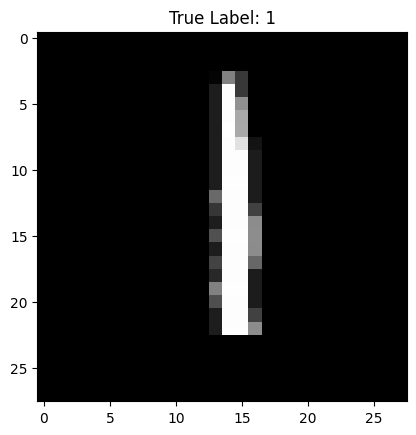

Predicted class: 1


In [13]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Shuffle indices
shuffled_indices = np.random.permutation(len(X_test))

# Select a sample image from the test dataset
sample_index = shuffled_indices[0]
sample_image = X_test[sample_index]
sample_label = y_test[sample_index]

# Display the sample image
plt.imshow(sample_image, cmap='gray')
plt.title(f'True Label: {sample_label}')
plt.show()

# Normalize the image
normalized_image = sample_image / 255.

# Get the trained layers from the model
trained_layers = Model.layers

# Run prediction
prediction_output = Model.predict(normalized_image, trained_layers)

# Get the predicted class
predicted_class = np.argmax(prediction_output)

print(f'Predicted class: {predicted_class}')
